In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, \
train_model_cross_val, train_model_test, \
get_feature_importance_cv, get_feature_importance, get_feature_importance10

### Load data

In [23]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_20.json")

### Balance data and split to train and test set

In [26]:
label_name = "competition"

In [27]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1316
1     267
Name: label, dtype: int64
Balancing...
Total decisions: 534
Labels distribution: 
 1    267
0    267
Name: 0, dtype: int64
Training set shape: (427,) (427,)
Test set shape: (107,) (107,)
Creating df_train 1: 214 0: 213
Creating df_test1 1: 53 0: 54
Creating df_test concatenated with df_excluded with len: 1049
Creating df_test 1: 53 0: 1103
Grouping df_train by case_num 1: 214 0: 213
Grouping df_test by case_num 1: 53 0: 1103
Grouping df_test1 by case_num 1: 53 0: 54
Grouping df_excluded by case_num with len: 1049


In [7]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [8]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2), (1,3), (2,2),(2,3), (2,4), (3,3), (3,4)], #(1,2),(1,1),(1,3),
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [9]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(1,2), (1,3), (2,2),(2,3),(3,3)], #(1,2),(1,1),(1,3),
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    # 'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    # 'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [10]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1')

Fitting 3 folds for each of 90 candidates, totalling 270 fits
done in 521.208s
Best cross-validation score:  0.6943366347714174
Best parameters set:
	clf__C: 1
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'


In [9]:
# grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1')

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
done in 2814.584s
Best cross-validation score:  0.9348109517601043
Best parameters set:
	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (3, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


##### Model fitting and evaluation

In [11]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=3)

fitting the best model
Accuracy: 0.6

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.29      0.42       207
           1       0.56      0.91      0.69       208

    accuracy                           0.60       415
   macro avg       0.66      0.60      0.56       415
weighted avg       0.66      0.60      0.56       415


CR: (0.660996835443038, 0.5992544593088072, 0.5572166803784451, None)

Confusion matrix:
 [[ 60 147]
 [ 19 189]] 

_______________________


 Accuracy: 60.00 
 Precision: 0.562 
 Recall: 0.909 
 F1: 0.695


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [12]:
# df_features_cv = get_feature_importance_cv(pipeline_cv)
# df_features_cv.to_excel('../../../output/tables/features_svm_cv_full.xlsx', index=True)
# df_features_cv.head()

In [13]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.4063573883161512

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.39      0.55      1111
           1       0.06      0.81      0.11        53

    accuracy                           0.41      1164
   macro avg       0.52      0.60      0.33      1164
weighted avg       0.94      0.41      0.53      1164


CR: (0.5183324962330488, 0.5991797292936841, 0.3325815453475027, None)

Confusion matrix:
 [[430 681]
 [ 10  43]] 

_______________________


 Accuracy: 40.64 
 Precision: 0.059 
 Recall: 0.811 
 F1: 0.111


### Model training (with 10-fold CV) using best parameters from GridSearch

In [14]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 1
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'


In [15]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (2,2), binary = True, max_df = 0.025, norm = 'l1', use_idf = True))
c = 1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [16]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.6602409638554216

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.48      0.58       207
           1       0.62      0.84      0.71       208

    accuracy                           0.66       415
   macro avg       0.68      0.66      0.65       415
weighted avg       0.68      0.66      0.65       415


CR: (0.6841872791519434, 0.6598035117056856, 0.6484508768451598, None)

Confusion matrix:
 [[ 99 108]
 [ 33 175]] 

_______________________


 Accuracy: 66.02 
 Precision: 0.618 
 Recall: 0.841 
 F1: 0.713


In [17]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.531786941580756

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.52      0.68      1111
           1       0.08      0.85      0.14        53

    accuracy                           0.53      1164
   macro avg       0.53      0.68      0.41      1164
weighted avg       0.94      0.53      0.65      1164


CR: (0.531786941580756, 0.6828541344700507, 0.4099092604564418, None)

Confusion matrix:
 [[574 537]
 [  8  45]] 

_______________________


 Accuracy: 53.18 
 Precision: 0.077 
 Recall: 0.849 
 F1: 0.142


In [22]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.7047619047619048

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.56      0.65        52
           1       0.66      0.85      0.74        53

    accuracy                           0.70       105
   macro avg       0.72      0.70      0.70       105
weighted avg       0.72      0.70      0.70       105


CR: (0.7227742448330683, 0.7033744557329463, 0.6977435230754945, None)

Confusion matrix:
 [[29 23]
 [ 8 45]] 

_______________________


 Accuracy: 70.48 
 Precision: 0.662 
 Recall: 0.849 
 F1: 0.744


### Feature importance

In [18]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
2070,human animal,0.636167,0.636167
175,air service,0.554842,0.554842
4400,software application,-0.531125,0.531125
2228,indirect subsidiary,0.528041,0.528041
2377,july party,0.518877,0.518877
868,concentration union,0.497350,0.497350
2288,international brand,0.489568,0.489568
4887,union belgië,-0.484938,0.484938
3130,particular relevant,0.474427,0.474427
3501,prior closing,0.453091,0.453091


In [270]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [19]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

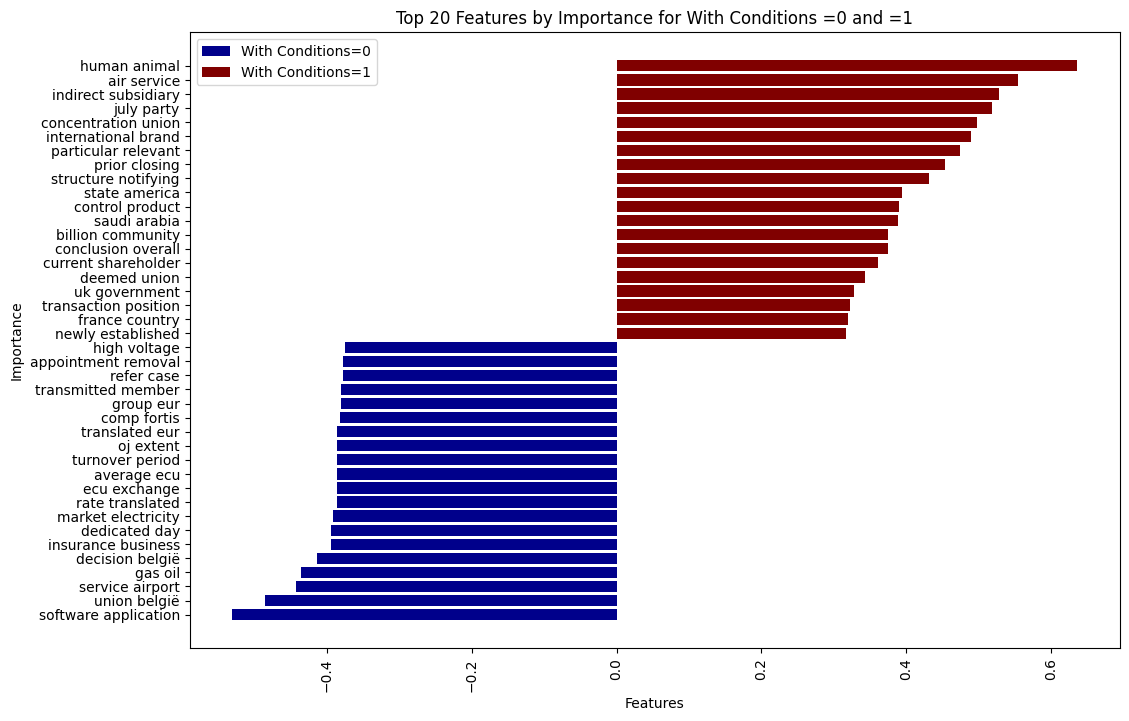

In [21]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='With Conditions=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='With Conditions=1')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Features by Importance for With Conditions =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [273]:
df_features_train.to_excel('../../../output/tables/features_svm_train_full_wc.xlsx', index=True)